<a href="https://colab.research.google.com/github/FaisalMoosani/Data-analysis-and-python-projects/blob/master/new_york_taxi_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROBLEM STATEMENT: FIND OUT THE PICKUP DENSITY GIVEN THE TIME AND REGION

In [0]:
import dask.dataframe as dd     #for importing data frame 
import pandas as pd             #for importing data frame
import folium                   #for open street map
import datetime                 #Convert to unix time
import time                     #Convert to unix time
import numpy as np              #Do aritmetic operations on arrays
import seaborn as sns           #Plots
import matplotlib.pylab as plt  #Plots
import matplotlib               #Plots
from matplotlib import rcParams #Size of plots  
import gpxpy.geo                #Get the haversine distance
from sklearn.cluster import MiniBatchKMeans, KMeans #Clustering
import math
import pickle
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import scipy

In [2]:
pip install gpxpy

     |████████████████████████████████| 112kB 2.8MB/s 
  Created wheel for gpxpy: filename=gpxpy-1.3.5-cp36-none-any.whl size=40315 sha256=581990b55d3ea57cd85af0f195c4e8e9b566dde8b6c375fc89a76718f1f167f0
  Stored in directory: /root/.cache/pip/wheels/d2/f0/5e/b8e85979e66efec3eaa0e47fbc5274db99fd1a07befd1b2aa4
Successfully built gpxpy


In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
link = 'https://drive.google.com/open?id=19pxY-1nlolOS0bQLDRYRjAW5Vuanm-CD'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Copy of yellow_tripdata_2015-01.csv')  
month = dd.read_csv('Copy of yellow_tripdata_2015-01.csv')
# Dataset is now stored in a dask Dataframe

19pxY-1nlolOS0bQLDRYRjAW5Vuanm-CD


In [9]:
print(month.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


In [10]:
month.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


# 1: Exploratory Data Analysis

##1.1 Work on latitude and longitude of New York *city*

new york city has latitude and longitude range as follows


1.   min_lat  = 40.5774
2.   max_lat  = 40.9176
3.   min_long =  74.15
4.   max_long = 73.7004

we will observe points beyond above values

In [11]:
outlier_locations = month[((month.pickup_longitude <= -74.15) | (month.pickup_latitude <= 40.5774) | \
                   (month.pickup_longitude >= -73.7004) | (month.pickup_latitude >= 40.9176))]
map_osm = folium.Map(location = [40.734695, -73.990372])

sample_location = outlier_locations.head(10000)
for i,j in sample_location.iterrows():
    if int(j['pickup_latitude'] != 0):
        folium.Marker(list((j['pickup_latitude'], j['pickup_longitude']))).add_to(map_osm)
  
map_osm

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:4553: UserWarning: Insufficient elements for `head`. 10000 elements requested, only 8003 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(msg.format(n, len(r)))


### As you can see above that there are some points just outside the boundary but many of them point to either South america, Mexico or Canada


 ## 1.2: Making new data frame with pickup times, trip times and speed

In [0]:
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

In [0]:
def return_with_times(month):
    duration = month[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].compute()
    #pickup and drop_off to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop   = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    #calculate duration of trips
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)
    
    # making new data frame with new modded varaibles.
    new_frame = month[['VendorID','payment_type','passenger_count','trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','RateCodeID','store_and_fwd_flag','total_amount','tolls_amount']].compute()
    new_frame['trip_times']   = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['speed']        = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

In [14]:
month.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

In [0]:
new_frame = return_with_times(month)

In [16]:
new_frame.columns

Index(['VendorID', 'payment_type', 'passenger_count', 'trip_distance',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'RateCodeID', 'store_and_fwd_flag', 'total_amount',
       'tolls_amount', 'trip_times', 'pickup_times', 'speed'],
      dtype='object')

## 1.3: Inspecting number of pickups by each vendors by vendor id

In [17]:
# get unique vendors

vendor_unique = new_frame.VendorID.unique()
vendors = []
#get the number of trip for each vendor
vendors.append(new_frame[new_frame['VendorID'] == 1].shape[0])
vendors.append(new_frame[new_frame['VendorID'] == 2].shape[0])
print('unique vendors: ', vendor_unique)
print('Vendor 1 count: ', vendors[0])
print('Vendor 2 count: ', vendors[1])

unique vendors:  [2 1]
Vendor 1 count:  6101189
Vendor 2 count:  6647797


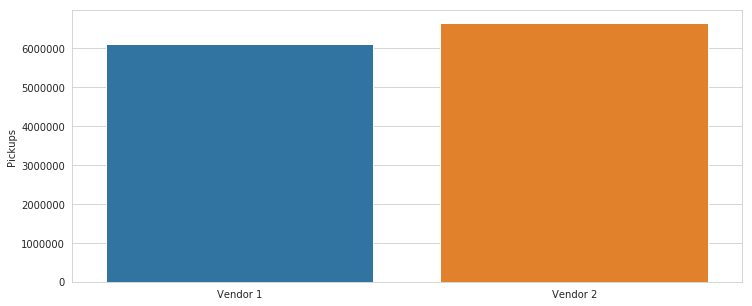

In [18]:
sns.set_style("whitegrid")

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

ax = sns.barplot(x = ['Vendor 1', 'Vendor 2'] , y = np.array(vendors))
ax.set(ylabel='Pickups')
plt.show()

In [19]:
print ("Vendor 1:{} % Vendor 2 :{} % ".format(100*float(vendors[1])/sum(vendors),100*float(vendors[0])/sum(vendors)))

Vendor 1:52.14373127400093 % Vendor 2 :47.85626872599907 % 


### Above analysis shows that both vendors share almost same number of pickups in JAN month

## 1.4: Inspecting Passenger count variable

In [20]:
passenger_count = []
passenger_unique = set(new_frame['passenger_count'].values)

for i in passenger_unique:
  passenger_count.append(new_frame[new_frame['passenger_count'] == i].shape[0])
  
pass_count_pickups = [x for _,x in sorted(zip(passenger_unique,passenger_count))]
pass_count = [int(y) for y,_ in sorted(zip(passenger_unique,passenger_count))]
print (pass_count)
print (pass_count_pickups)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[6565, 8993870, 1814594, 528486, 253228, 697645, 454568, 9, 10, 11]


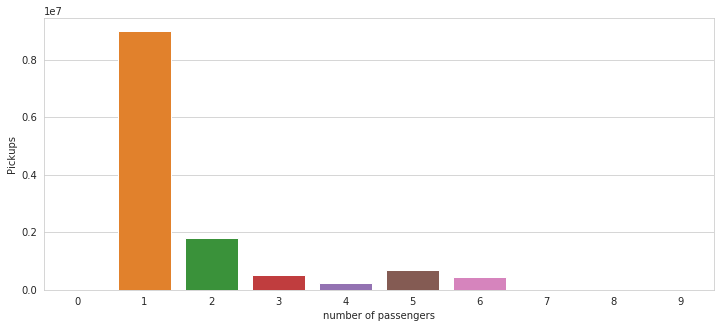

In [21]:
sns.set_style("whitegrid")

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

ax = sns.barplot(x = np.array(pass_count) , y = np.array(pass_count_pickups))
ax.set(ylabel='Pickups',xlabel = 'number of passengers')
plt.show()

In [22]:
for a,b in zip(pass_count,pass_count_pickups):
    print ("Pickups for passenger count {} : {}% of total pickups".format(int(a),round(float(b)*100/sum(pass_count_pickups),4)))

Pickups for passenger count 0 : 0.0515% of total pickups
Pickups for passenger count 1 : 70.5458% of total pickups
Pickups for passenger count 2 : 14.2332% of total pickups
Pickups for passenger count 3 : 4.1453% of total pickups
Pickups for passenger count 4 : 1.9863% of total pickups
Pickups for passenger count 5 : 5.4722% of total pickups
Pickups for passenger count 6 : 3.5655% of total pickups
Pickups for passenger count 7 : 0.0001% of total pickups
Pickups for passenger count 8 : 0.0001% of total pickups
Pickups for passenger count 9 : 0.0001% of total pickups


### Inference from the passenger count:
1. Majority of the trips seem to have 1 and 2 passengers.
2. 0 passenger count maybe an error or some kind of goods delivery
3. According to the TLC regulations 5 is the maximum number of passengers allowed in a yellow taxi
  - Good amount of trips have more than 5 passengers - almost 45k of them
  - Toddlers and children below age 7 are allowed to sit on laps
  - Maybe the drivers take into account the toddlers too(But still 7 ,8 and 9 are ridiculous numbers for passenger counts)

## 1.5: Analyzing Rate Code feature

In [0]:
## Rate Code:
#1. Standard rate
#2. JFK
#3. Newark
#4. Nassau or Westchester
#5. Negotiated fare
#6. Group ride
# unique rate codes
rate_code_unique = set(new_frame['RateCodeID'].values)

In [0]:
##Unique rate codes
rate_codes_uniq = set(new_frame['RateCodeID'].values)
rate_count = []
for i in rate_codes_uniq:
    rate_count.append(new_frame[new_frame['RateCodeID'] == i].shape[0])
#sort the pickups based on the rate codes
rate_code_pickups = [x for _,x in sorted(zip(rate_codes_uniq,rate_count))]
rate_code = [int(y) for y,_ in sorted(zip(rate_codes_uniq,rate_count))]
Trips = ['Standard rates','JFK trips','Newark trips','Nassau/Westchester trips','Negotiated fare','Group rides','unknownrate code']


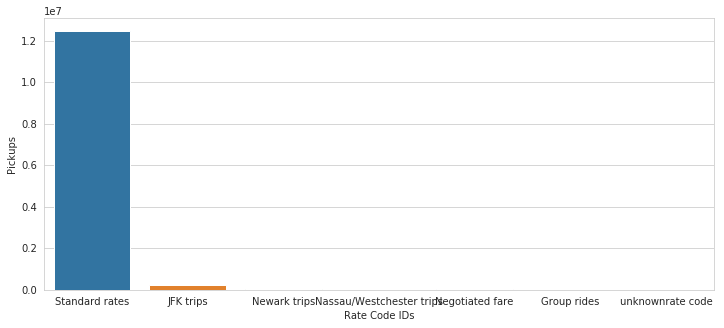

In [25]:
sns.set_style("whitegrid")

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

ax = sns.barplot(x = np.array(Trips) , y = np.array(rate_code_pickups))
ax.set(ylabel='Pickups',xlabel = 'Rate Code IDs')
plt.show()

In [26]:
for a,b in zip(Trips,rate_code_pickups):
    print ("Pickups for/with {} accounts {}% of total pickups".format(a,round(float(b)*100/sum(rate_code_pickups),4)))

Pickups for/with Standard rates accounts 97.7717% of total pickups
Pickups for/with JFK trips accounts 1.7627% of total pickups
Pickups for/with Newark trips accounts 0.1388% of total pickups
Pickups for/with Nassau/Westchester trips accounts 0.0324% of total pickups
Pickups for/with Negotiated fare accounts 0.2894% of total pickups
Pickups for/with Group rides accounts 0.0011% of total pickups
Pickups for/with unknownrate code accounts 0.004% of total pickups


## Inference from Rate code:

1. Standard rate - 12.4 Million trips
2. JFK - 224.2k trips
3. Newark - 17.7k trips
4. Nassau or Westchester - 4.1k trips
5. Negotiated fare - 36.8k trips
6. Group ride - 134 trips
7. rate code 99(mistake??) - 507 trips

## 1.6: Analyzing Store and forward flag

1.   List item
2.   List item



Store_and_fwd_flag
This flag indicates whether the trip record was held in vehicle memory before sending to the vendor,<br\> aka “store and forward,” because the vehicle did not have a connection to the server.
		Y= store and forward trip
		N= not a store and forward trip

In [27]:
SWflag_uniq = set(new_frame['store_and_fwd_flag'].values)
SWflag_count = []
for i in SWflag_uniq :
    SWflag_count.append(new_frame[new_frame['store_and_fwd_flag'] == i].shape[0])
print (SWflag_count)
SWflag_uniq = list(SWflag_uniq)
print (SWflag_uniq)

[12633953, 115033]
['N', 'Y']


In [28]:
for a,b in zip(SWflag_uniq,SWflag_count):
    print ("Pickups for/with store and forward = {} accounts {}% of total pickups".format(a,round(float(b)*100/sum(SWflag_count),4)))

Pickups for/with store and forward = N accounts 99.0977% of total pickups
Pickups for/with store and forward = Y accounts 0.9023% of total pickups


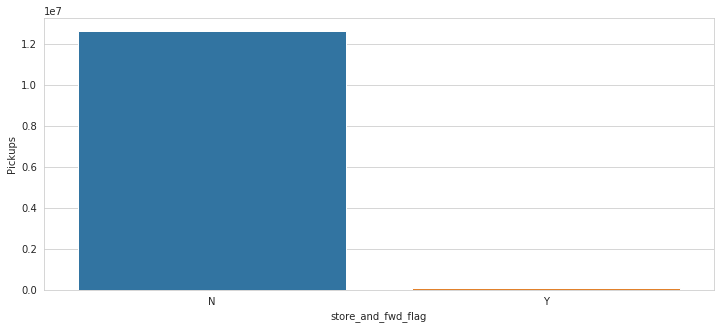

In [29]:
sns.set_style("whitegrid")

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

ax = sns.barplot(x = np.array(SWflag_uniq) , y = np.array(SWflag_count))
ax.set(ylabel='Pickups',xlabel = 'store_and_fwd_flag')
plt.show()

## 1.6: Analyzing Payment types

Payment types are:
1. Credit card
2. Cash
3. No charge.
4. Disput
5. Unknown
6. Voided Trip

In [30]:
payment_uniq = set(new_frame['payment_type'].values)
payment_count = []
for i in payment_uniq :
    payment_count.append(new_frame[new_frame['payment_type'] == i].shape[0])
print (payment_count)
payment_uniq = list(payment_uniq)
print (payment_uniq)

[7881388, 4816992, 38632, 11972, 2]
[1, 2, 3, 4, 5]


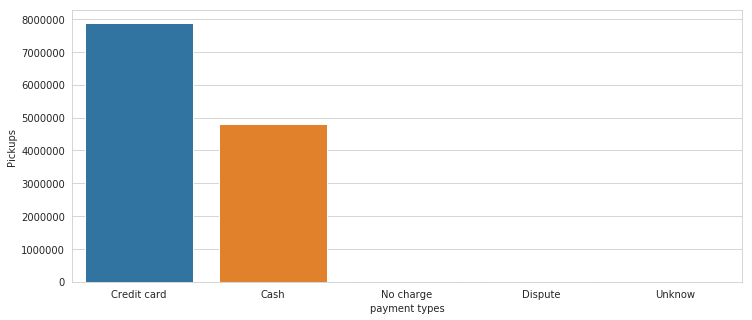

In [31]:
pay_pickups = [x for _,x in sorted(zip(payment_uniq,payment_count))]
pay = [int(y) for y,_ in sorted(zip(payment_uniq,payment_count))]
pay_type = ['Credit card','Cash','No charge','Dispute','Unknow']

sns.set_style("whitegrid")

fig, ax = plt.subplots()
fig.set_size_inches(12, 5)

ax = sns.barplot(x = np.array(pay_type) , y = np.array(pay_pickups))
ax.set(ylabel='Pickups',xlabel = 'payment types')
plt.show()

## 1.7: Analyzing Trip Times

In NY maximum allowed trip duration in 24 hours is 12 hours means allowerd work hour for drivers is 12 hours and allowed time for 1 trip is also 12 hours


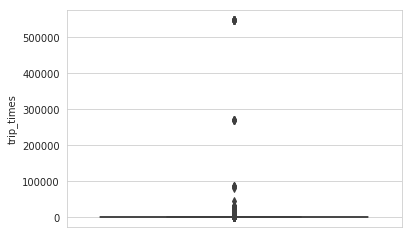

In [32]:
# plotting box plot for outlier checking
sns.boxplot(y = 'trip_times', data = new_frame)
plt.show()

In [33]:
# calculating 0-100th percentile to find correct value of outliers
for i in range(0,101,10):
  var = new_frame["trip_times"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i)
  print(i,"th percentile value is: ",percentile_val)

0 th percentile value is:  -1211.0166666666667
10 th percentile value is:  3.8333333333333335
20 th percentile value is:  5.383333333333334
30 th percentile value is:  6.816666666666666
40 th percentile value is:  8.3
50 th percentile value is:  9.95
60 th percentile value is:  11.866666666666667
70 th percentile value is:  14.283333333333333
80 th percentile value is:  17.633333333333333
90 th percentile value is:  23.45
100 th percentile value is:  548555.6333333333


In [34]:
# looking further from 99 percentile to 100th percentile
for i in range(0,101,10):
  var = new_frame["trip_times"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i)
  print(i,"th percentile value is: ",percentile_val)
print("100 percentile value is ", var[-1])

0 th percentile value is:  -1211.0166666666667
10 th percentile value is:  3.8333333333333335
20 th percentile value is:  5.383333333333334
30 th percentile value is:  6.816666666666666
40 th percentile value is:  8.3
50 th percentile value is:  9.95
60 th percentile value is:  11.866666666666667
70 th percentile value is:  14.283333333333333
80 th percentile value is:  17.633333333333333
90 th percentile value is:  23.45
100 th percentile value is:  548555.6333333333
100 percentile value is  548555.6333333333


In [0]:
# removing data bases on analysis and TLC regulations

new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]

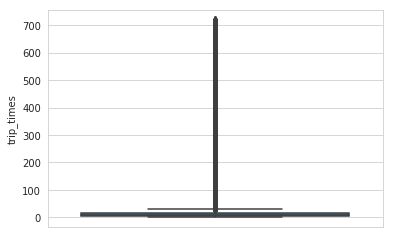

In [36]:
sns.boxplot(y = 'trip_times', data = new_frame)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


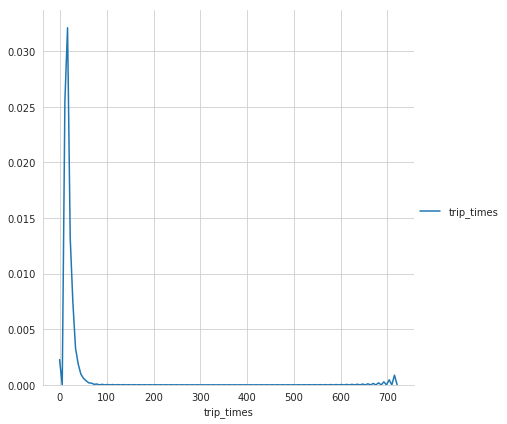

In [37]:
# pdf of trip_times after removing outliers
sns.FacetGrid(new_frame , size = 6).map(sns.kdeplot, "trip_times").add_legend()
plt.show()

In [0]:
# convertig trip_time values to log form inorder to check log normal

new_frame['log_times'] = np.log(new_frame['trip_times'])
    

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


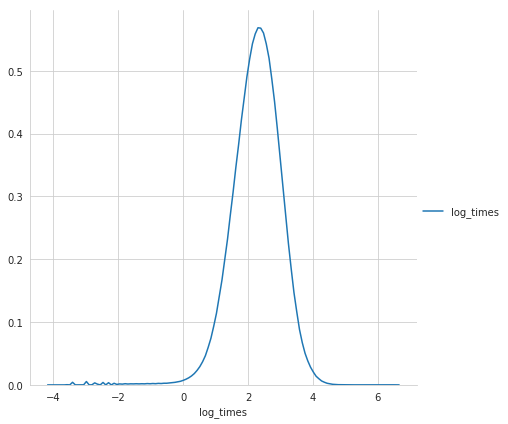

In [39]:
# pdf of trip_times after removing outliers
sns.FacetGrid(new_frame , size = 6).map(sns.kdeplot, "log_times").add_legend()
plt.show()

above plot shows that after taking log of trip times it resembles to normal distribution but not completly

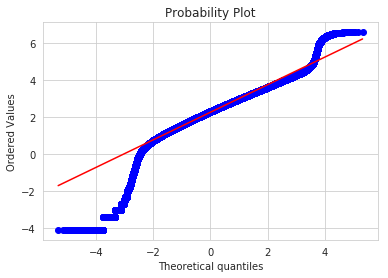

In [40]:
# Q-Q plot to check if trip_time is log_normal
scipy.stats.probplot(new_frame['log_times'].values, plot = plt)
plt.show()

so it seems that trip time behave as normal distribution from range of -2 to 4, from tails it does not resembles normal dist.

 ## 1.8 Analyzing Speed

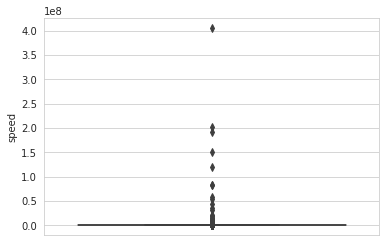

In [41]:
# plotting speed feature to check outliers

sns.boxplot(y = 'speed', data = new_frame)
plt.show()

In [42]:
# calculating speed value in each outlier
for i in range(0,101,10):
  var = new_frame["speed"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i)
  print(i,"th percentile value is: ",percentile_val)

0 th percentile value is:  0.0
10 th percentile value is:  6.3458980044345905
20 th percentile value is:  7.771217712177122
30 th percentile value is:  8.902627511591964
40 th percentile value is:  9.960474308300395
50 th percentile value is:  11.052631578947368
60 th percentile value is:  12.277087033747781
70 th percentile value is:  13.793322734499206
80 th percentile value is:  15.973509933774835
90 th percentile value is:  20.233740635556018
100 th percentile value is:  406256374.28571427


In [43]:
# calculating percentile value between 90th and 100th percentile
for i in range(90,101):
  var = new_frame["speed"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i)
  print(i,"th percentile value is: ",percentile_val)

90 th percentile value is:  20.233740635556018
91 th percentile value is:  20.97087378640777
92 th percentile value is:  21.81818181818182
93 th percentile value is:  22.790152403282534
94 th percentile value is:  23.927492447129907
95 th percentile value is:  25.277206444638658
96 th percentile value is:  26.922888616891065
97 th percentile value is:  28.99192245557351
98 th percentile value is:  31.811487481590575
99 th percentile value is:  36.12428650973351
100 th percentile value is:  406256374.28571427


In [44]:
#checking percentile value between 99th and 100th percentile
for i in np.arange(0.0, 1.0, 0.1):
  var = new_frame["speed"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i+99)
  print(i+99,"th percentile value is: ",percentile_val)
  
print(100,"th percentile value  is: ",var[-1])

99.0 th percentile value is:  36.12428650973351
99.1 th percentile value is:  36.71641791044775
99.2 th percentile value is:  37.370600856535546
99.3 th percentile value is:  38.09372215739944
99.4 th percentile value is:  38.90800972326104
99.5 th percentile value is:  39.84
99.6 th percentile value is:  40.95531083826694
99.7 th percentile value is:  42.352941176470594
99.8 th percentile value is:  44.4
99.9 th percentile value is:  49.44450477126318
100 th percentile value  is:  406256374.28571427


In [0]:
# removing outliers from speed 

new_frame = new_frame[(new_frame.speed < 45.31) & (new_frame.speed > 0)]

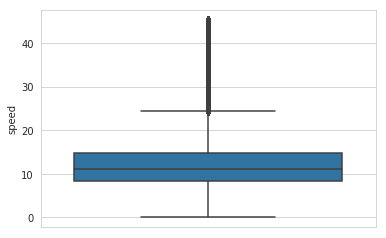

In [46]:
sns.boxplot(y = 'speed', data = new_frame)
plt.show()

In [47]:
print('mean speed is found to be ', new_frame['speed'].mean())

mean speed is found to be  12.458636437076578


 ## 1.9 Analyzing trip distance

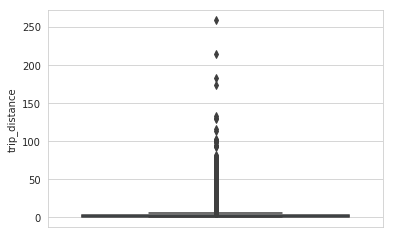

In [48]:
# plotting speed feature to check outliers

sns.boxplot(y = 'trip_distance', data = new_frame)
plt.show()

In [49]:
for i in range(0,101,10):
  var = new_frame["trip_distance"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i)
  print(i,"th percentile value is: ",percentile_val)

0 th percentile value is:  0.01
10 th percentile value is:  0.66
20 th percentile value is:  0.9000000000000001
30 th percentile value is:  1.1
40 th percentile value is:  1.39
50 th percentile value is:  1.69
60 th percentile value is:  2.07
70 th percentile value is:  2.6
80 th percentile value is:  3.6
90 th percentile value is:  5.96
100 th percentile value is:  258.9


In [50]:
for i in range(90,101):
  var = new_frame["trip_distance"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i)
  print(i,"th percentile value is: ",percentile_val)

90 th percentile value is:  5.96
91 th percentile value is:  6.45
92 th percentile value is:  7.07
93 th percentile value is:  7.84
94 th percentile value is:  8.72
95 th percentile value is:  9.6
96 th percentile value is:  10.6
97 th percentile value is:  12.1
98 th percentile value is:  16.03
99 th percentile value is:  18.17
100 th percentile value is:  258.9


In [51]:
for i in np.arange(0.0, 1.0, 0.1):
  var = new_frame["trip_distance"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i+99)
  print(i+99,"th percentile value is: ",percentile_val)
  
print(100,"th percentile value  is: ",var[-1])

99.0 th percentile value is:  18.17
99.1 th percentile value is:  18.36
99.2 th percentile value is:  18.6
99.3 th percentile value is:  18.83
99.4 th percentile value is:  19.13
99.5 th percentile value is:  19.5
99.6 th percentile value is:  19.96
99.7 th percentile value is:  20.5
99.8 th percentile value is:  21.22
99.9 th percentile value is:  22.57
100 th percentile value  is:  258.9


In [0]:
new_frame = new_frame[(new_frame.trip_distance >0) & (new_frame.trip_distance<23)]

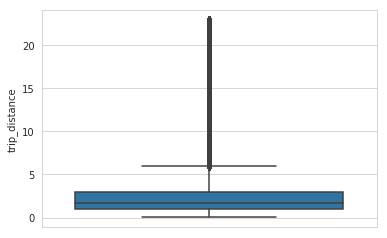

In [53]:
sns.boxplot(y = "trip_distance", data= new_frame)
plt.show()

 ## 1.10 Analyzing Fare

In [54]:
month.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')

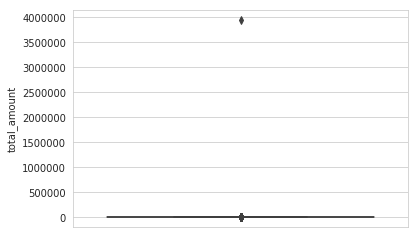

In [55]:
sns.boxplot(y = 'total_amount', data = new_frame)
plt.show()

In [56]:
for i in range(0,101,10):
  var = new_frame["total_amount"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i)
  print(i,"th percentile value is: ",percentile_val)

0 th percentile value is:  -242.55
10 th percentile value is:  6.35
20 th percentile value is:  7.799999999999999
30 th percentile value is:  8.8
40 th percentile value is:  9.8
50 th percentile value is:  11.16
60 th percentile value is:  12.8
70 th percentile value is:  14.8
80 th percentile value is:  18.3
90 th percentile value is:  25.8
100 th percentile value is:  3950611.6


In [57]:

for i in range(90,101):
  var = new_frame["total_amount"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i)
  print(i,"th percentile value is: ",percentile_val)

90 th percentile value is:  25.8
91 th percentile value is:  27.3
92 th percentile value is:  29.12
93 th percentile value is:  31.55
94 th percentile value is:  34.63
95 th percentile value is:  38.15
96 th percentile value is:  42.13
97 th percentile value is:  47.56
98 th percentile value is:  57.76
99 th percentile value is:  65.93
100 th percentile value is:  3950611.6


In [58]:
for i in np.arange(0.0, 1.0, 0.1):
  var = new_frame["total_amount"].values
  var = np.sort(var, axis = None)
  percentile_val = np.percentile(var, i+99)
  print(i+99,"th percentile value is: ",percentile_val)
  
print(100,"th percentile value  is: ",var[-1])

99.0 th percentile value is:  65.93
99.1 th percentile value is:  67.8
99.2 th percentile value is:  69.06
99.3 th percentile value is:  69.6
99.4 th percentile value is:  69.73
99.5 th percentile value is:  69.73
99.6 th percentile value is:  69.76
99.7 th percentile value is:  72.46
99.8 th percentile value is:  75.3
99.9 th percentile value is:  87.0
100 th percentile value  is:  3950611.6


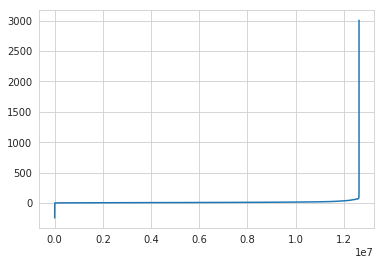

In [59]:
#plot the fare amount excluding last two values in sorted data
plt.plot(var[:-2])
plt.show()

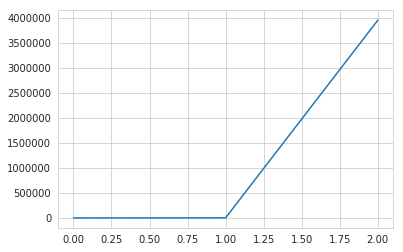

In [60]:
# plotting last 3 fare values
plt.plot(var[-3:])
plt.show()

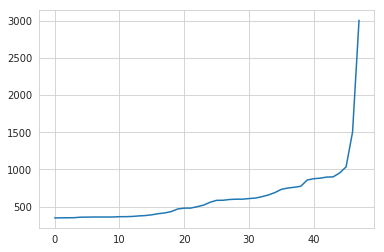

In [61]:
# plotting last 50 values excluding last two values
plt.plot(var[-50:-2])
plt.show()

In [0]:
new_frame = new_frame[(new_frame.total_amount <1000) & (new_frame.total_amount >0)]

In [0]:
# removing drop off and pickup outliers
new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]

In [64]:
print(float(len(new_frame)/len(month)))

0.9703576425607495


# 2.0: DATA PREPERATION

Businesss problem we are solving is to predict number of pickups using Region and time bin. early we cleaned the data and removed all outliers, now we need to preprocess data inorder to solve our problem. in this case there are 2 preprocessing stages. 


1.   Breaking whole NewYork into segments/clusters.
2.   Breaking time into 10 min bins.

here we will work on 1st stage for that we will use K means clustering to cluster whole data into segments. here we need to see two important things that is driver takes 10 mins to complete 2 miles i.e. inter cluster distance is 2 miles. and cluster size should not be very small so minimum intercluster distance should not exceed 0.5 miles (just and assumption.)



## 2.1: Clustering/Segmentation

In [0]:
coords = new_frame[['pickup_latitude', 'pickup_longitude']].values
def find_clusters(i):

  kmeans = MiniBatchKMeans(n_clusters = i, batch_size = 10000, random_state = 42).fit(coords)
  new_frame['pickup_cluster'] = kmeans.predict(new_frame[['pickup_latitude','pickup_longitude']])
  cluster_centers = kmeans.cluster_centers_
  cluster_len     = len(cluster_centers)
  return cluster_centers, cluster_len

In [0]:
neighbours = []
def find_min_distance(cluster_centers, cluster_len):
  nice_points = 0
  wrong_points = 0
  less2 = []
  more2 = []
  min_dist = 1000
  for i in range(0, cluster_len):
    nice_points = 0
    wrong_points = 0
    for j in range(0, cluster_len):
      
      if j!=i:
        distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1], cluster_centers[j][0], cluster_centers[j][1])
        min_dist = min(min_dist, distance/(1.60934*1000) )
        if (distance/(1.60934*1000)) <= 2:
          nice_points += 1
        else:
          wrong_points += 1
    less2.append(nice_points)
    more2.append(wrong_points)
  neighbours.append(less2)
  print("on choosing a cluster size of ",cluster_len,"\nAvg number of clusters within the vicinity (i.e. intercluster-distance < 2):" ,np.ceil(sum(less2)/len(less2)), "\nAvg number of clusters outside the vicinity (i.e. intercluster-distance > 2):", np.ceil(sum(more2)/len(more2)),"\nMin inter cluster distance is:", min_dist)

In [67]:
for i in range(10,100,10):
  cluster_centers, cluster_len = find_clusters(i)
  find_min_distance(cluster_centers, cluster_len)

on choosing a cluster size of  10 
Avg number of clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg number of clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter cluster distance is: 1.0945442325142543
on choosing a cluster size of  20 
Avg number of clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg number of clusters outside the vicinity (i.e. intercluster-distance > 2): 16.0 
Min inter cluster distance is: 0.7131298007387813
on choosing a cluster size of  30 
Avg number of clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg number of clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter cluster distance is: 0.5185088176172206
on choosing a cluster size of  40 
Avg number of clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg number of clusters outside the vicinity (i.e. intercluster-distance > 2): 32.0 
Min inter cluster distance is: 0.50697684503639

from above we can infer that minimum distance between 40 and 50 clusters is very large. we will take 40 clusters for our future work

In [0]:
# making 40 clusters
kmeans = MiniBatchKMeans(n_clusters = 40, batch_size = 10000, random_state = 0).fit(coords)
new_frame['pickup_clusters'] = kmeans.predict(new_frame[['pickup_latitude','pickup_longitude']])
new_frame['dropoff_clusters'] = kmeans.predict(new_frame[['dropoff_latitude','dropoff_longitude']])

## 2.2: Work on pickups per day

In [0]:
def compute_pickups_per_day():
    time = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    time['tpep_pickup_datetime'] = pd.to_datetime(time['tpep_pickup_datetime'])
    time["pickup_day"] = time['tpep_pickup_datetime'].dt.strftime('%u').astype(int)
    time["pickup_hour"] = time['tpep_pickup_datetime'].dt.strftime('%H').astype(int)
    set(time['pickup_day'].values)
    day_pickups = []
    night_pickups = []
    mid_night_pickups = []
    afternoon_pickups = []
    for i in range(1,8):
        day_pickups.append(time[(time.pickup_day == i) & (time.pickup_hour >= 6) & (time.pickup_hour < 12)].shape[0])
        night_pickups.append(time[(time.pickup_day == i) & (time.pickup_hour >= 18) & (time.pickup_hour <= 23)].shape[0])
        mid_night_pickups.append(time[(time.pickup_day == i) & (time.pickup_hour >= 0) & (time.pickup_hour < 6)].shape[0])
        afternoon_pickups.append(time[(time.pickup_day == i) & (time.pickup_hour >= 12) & (time.pickup_hour < 18)].shape[0])
    
    days =pd.DataFrame({'morning':day_pickups, 'afternoon':afternoon_pickups, 'night':night_pickups, 'midnight':mid_night_pickups})
    days.plot(kind='bar', stacked=True,figsize=(4.5, 4.5))
    plt.xlabel('Days of the week')
    plt.ylabel('Number of pickups')
    plt.tick_params(axis='both', which='minor')
    plt.plot()
    days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    for i in range(0,len(days)):
        print ("{} -  morning:{} , day:{} , mid-day:{} night:{}".format(days[i],mid_night_pickups[i],day_pickups[i],afternoon_pickups[i],night_pickups[i]))
    
    return time

Monday -  morning:108576 , day:408179 , mid-day:434850 night:381266
Tuesday -  morning:76339 , day:372232 , mid-day:415968 night:509383
Wednesday -  morning:104280 , day:481818 , mid-day:488264 night:609625
Thursday -  morning:260968 , day:545611 , mid-day:606775 night:754859
Friday -  morning:200685 , day:547113 , mid-day:629661 night:849728
Saturday -  morning:433710 , day:399576 , mid-day:724563 night:821859
Sunday -  morning:377923 , day:276211 , mid-day:525948 night:403016


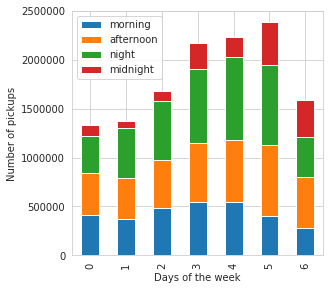

In [70]:
times_of_day = compute_pickups_per_day()

1. saturday seems to be busiest day for the taxi driveer overall.
2. most midnight commutes happens on saturday.
3. friday night commutes are higher as compared to saturday  night commutes.

## 2.3: Work on pickup for every hour

In [0]:
def pickup_in_hour(dframe):
  hour_pickups = []
  temp = []
  
  for i in range(1,8):
    for j in range(0,24):
      temp.append(dframe[(dframe.pickup_day == i) & (dframe.pickup_hour == j)].shape[0])
    hour_pickups.append(temp)
    temp = []
  color = ['blue', 'orange', 'brown', 'coral', 'magenta', 'green', 'fuchsia']
  days = ['Monday', 'Tuesday', "wednesday", 'Thursday', 'Friday', 'Saturday', 'Sunday']
                  
  plt.figure(figsize =(8,4))
  hours_list = [s for s in range(0,24)]
  for k in range(0,7):
    plt.plot(hours_list, hour_pickups[k], color[k], label = days[k])
    plt.plot(hours_list, hour_pickups[k], 'ro', markersize = 2)
  plt.xticks([s for s in range(0,24)])
  plt.xlabel('Hours of a day')
  plt.ylabel('Number of pickups')
  plt.title('Pickups for every hour')
  plt.legend()
  plt.grid(True)
  plt.show()
    

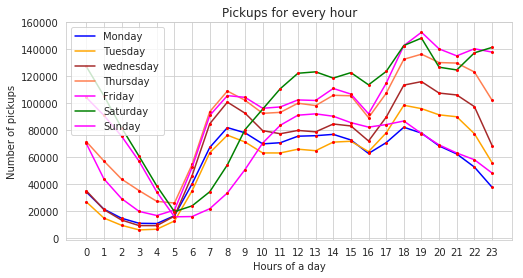

In [72]:
pickup_in_hour(times_of_day)

## 2.4: Pickup for every hour for whole month

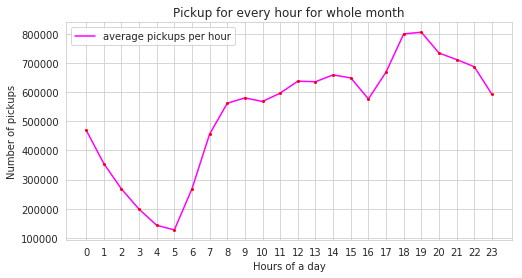

In [73]:
def pickup_in_hour_month(dframe):
  hour_pickups_month = []
  
  for j in range(0,24):
      hour_pickups_month.append(dframe[dframe.pickup_hour == j].shape[0])
                  
  plt.figure(figsize =(8,4))
  hours_list = [s for s in range(0,24)]
  plt.plot(hours_list, hour_pickups_month, 'magenta', label = 'average pickups per hour')
  plt.plot(hours_list, hour_pickups_month, 'ro', markersize = 2)
  plt.xticks([s for s in range(0,24)])
  plt.xlabel('Hours of a day')
  plt.ylabel('Number of pickups')
  plt.title('Pickup for every hour for whole month')
  plt.legend()
  plt.grid(True)
  plt.show()

pickup_in_hour_month(times_of_day)



In [0]:
### function to remove outliers
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

def remove_outliers(new_frame):

    a = new_frame.shape[0]
    print("Number of pickup records = ", a)
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]

    b = temp_frame.shape[0]
    print("number of outlier coordinates lying outside NY boundries = ",(a-b))
    
    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print("number of outlier from trip times analysis = ",(a-c))
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]    
    d = new_frame.shape[0]
    print("number of outlier from trip distance analysis = ",(a-d))
    
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    temp_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print("number of outlier from trip speed analysis = ",(a-e))
    
    temp_frame = new_frame[(new_frame.total_amount < 1000) & (new_frame.total_amount > 0)]
    f = temp_frame.shape[0]
    print("number of outliers from fare analysis = ", (a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
                       (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
                       ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
                       (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))] 
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed <= 65) & (new_frame.Speed >= 0)]
    new_frame = new_frame[(new_frame.total_amount <= 65) & (new_frame.total_amount >= 0)]

    print("Total outliers removed", a - new_frame.shape[0])
    print("---")
  
    return new_frame
  


## 2.5: Time binning

after making clusters next step is to make 10 mins time bins. 

In [0]:
def add_pickup_bins(frame,month,year):
  unix_pickup_times = [i for i in frame['pickup_times'].values]
  #jan 2015,feb 2015, mar 2015, jan 2016,feb 2016 ,mar 2016
  unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
  
  start_pickup_unix = unix_times[year-2015][month-1]
  ten_min_bin = [(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
  frame['pickup_bins'] = np.array(ten_min_bin)
  
  return frame

In [0]:
new_frame['pickup_cluster'] = kmeans.predict(new_frame[['pickup_latitude', 'pickup_longitude']])

In [0]:
jan_2015_frame = add_pickup_bins(new_frame, 1, 2015)

In [0]:
jan_2015_groupby = jan_2015_frame[['pickup_clusters','pickup_bins','trip_distance']].groupby(['pickup_clusters','pickup_bins']).count()

In [79]:
jan_2015_groupby.head()

trip_distance
pickup_clusters pickup_bins               
0               33                     104
                34                     200
                35                     208
                36                     141
                37                     155

# 3: Applying all steps on remaining Data

till now we have cleaned our one month data and applied 2 main pre processising work that is making clusters and time bins. now we will perform above activities on our remaining data sets of year 2016. for this we will make a function below.

In [0]:
def datapreparation(month, kmeans, month_no, year_no):
  print('Return with trip times.')
  dframe_with_duration = return_with_times(month)
  
  print("Remove outliers")
  new_frame1 = remove_outliers(dframe_with_duration)
  
  print("Clustering")
  new_frame1['pickup_cluster'] = kmeans.predict(new_frame1[['pickup_latitude','pickup_longitude']])
  
  print('Final groupby')
  final_updated_frame = add_pickup_bins(new_frame1,month_no,year_no)
  final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
  
  return final_updated_frame, final_groupby_frame

In [81]:
link = 'https://drive.google.com/open?id=19pxY-1nlolOS0bQLDRYRjAW5Vuanm-CD'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Copy of yellow_tripdata_2016-01.csv')  
#month = dd.read_csv('Copy of yellow_tripdata_2015-01.csv')
# Dataset is now stored in a dask Dataframe
month_jan_2016 = dd.read_csv('Copy of yellow_tripdata_2016-01.csv')

19pxY-1nlolOS0bQLDRYRjAW5Vuanm-CD


In [82]:
link = 'https://drive.google.com/open?id=19pxY-1nlolOS0bQLDRYRjAW5Vuanm-CD'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Copy of yellow_tripdata_2016-02.csv')  
#month = dd.read_csv('Copy of yellow_tripdata_2015-01.csv')
# Dataset is now stored in a dask Dataframe
month_feb_2016 = dd.read_csv('Copy of yellow_tripdata_2016-02.csv')

19pxY-1nlolOS0bQLDRYRjAW5Vuanm-CD


In [83]:
link = 'https://drive.google.com/open?id=19pxY-1nlolOS0bQLDRYRjAW5Vuanm-CD'
fluff, id = link.split('=')
print (id)
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Copy of yellow_tripdata_2016-03.csv')  
#month = dd.read_csv('Copy of yellow_tripdata_2015-01.csv')
# Dataset is now stored in a dask Dataframe
month_march_2016 = dd.read_csv('Copy of yellow_tripdata_2016-03.csv')

19pxY-1nlolOS0bQLDRYRjAW5Vuanm-CD


In [84]:
jan_2016_frame, jan_2016_groupby = datapreparation(month_jan_2016, kmeans, 1, 2016)

Return with trip times.
Remove outliers
Number of pickup records =  12748986
number of outlier coordinates lying outside NY boundries =  293919
number of outlier from trip times analysis =  23889
number of outlier from trip distance analysis =  0
number of outlier from trip speed analysis =  24473
number of outliers from fare analysis =  5275
Total outliers removed 485773
---
Clustering
Final groupby


In [85]:
feb_2016_frame, feb_2016_groupby = datapreparation(month_feb_2016, kmeans, 2, 2016)
march_2016_frame, march_2016_groupby = datapreparation(month_march_2016, kmeans, 3, 2016)

Return with trip times.
Remove outliers
Number of pickup records =  12748986
number of outlier coordinates lying outside NY boundries =  293919
number of outlier from trip times analysis =  23889
number of outlier from trip distance analysis =  0
number of outlier from trip speed analysis =  24473
number of outliers from fare analysis =  5275
Total outliers removed 485773
---
Clustering
Final groupby
Return with trip times.
Remove outliers
Number of pickup records =  12748986
number of outlier coordinates lying outside NY boundries =  293919
number of outlier from trip times analysis =  23889
number of outlier from trip distance analysis =  0
number of outlier from trip speed analysis =  24473
number of outliers from fare analysis =  5275
Total outliers removed 485773
---
Clustering
Final groupby


# 4: SMOOTHING



In [0]:
# making unique bins where pickup values are present for each region

def return_bins(frame):
  values = []
  for i in range(0, 40):
    val = frame[frame['pickup_cluster'] == i]
    lis = list(set(val['pickup_bins']))
    lis.sort()
    values.append(lis)
  return values
    
    

In [0]:
jan_2015_uni = return_bins(jan_2015_frame)
jan_2016_uni = return_bins(jan_2016_frame)

feb_2016_uni = return_bins(feb_2016_frame)
march_2016_uni = return_bins(march_2016_frame)

In [88]:
# number of 10 min indices for jan 2015, jan 2016, fen 2016 and march 2016 are:

print("jan_2015_indices =", 24*31*60/10)
print("jan_2016_indices =" ,24*31*60/10)
print("feb_2016_indices =" ,24*29*60/10)
print("jan_2015_indices =", 24*30*60/10)

jan_2015_indices = 4464.0
jan_2016_indices = 4464.0
feb_2016_indices = 4176.0
jan_2015_indices = 4320.0


since maximum number of indices are 4464 so we will take this number as base

In [89]:
#cheking 0 pickups for each cluster for jan 2015
for i in range(40):
  print("for ",i," cluster number of bins with 0 pickups are: ",4464-len(jan_2015_uni[i]))


for  0  cluster number of bins with 0 pickups are:  40
for  1  cluster number of bins with 0 pickups are:  1985
for  2  cluster number of bins with 0 pickups are:  29
for  3  cluster number of bins with 0 pickups are:  354
for  4  cluster number of bins with 0 pickups are:  37
for  5  cluster number of bins with 0 pickups are:  153
for  6  cluster number of bins with 0 pickups are:  34
for  7  cluster number of bins with 0 pickups are:  34
for  8  cluster number of bins with 0 pickups are:  117
for  9  cluster number of bins with 0 pickups are:  40
for  10  cluster number of bins with 0 pickups are:  25
for  11  cluster number of bins with 0 pickups are:  44
for  12  cluster number of bins with 0 pickups are:  42
for  13  cluster number of bins with 0 pickups are:  28
for  14  cluster number of bins with 0 pickups are:  26
for  15  cluster number of bins with 0 pickups are:  31
for  16  cluster number of bins with 0 pickups are:  40
for  17  cluster number of bins with 0 pickups are:  

from above we can see that there are many bins with no pickups in each cluster, we need to fill these values. for this we can perform 2 operations:
1) fill empty values with 0
2) fill empty values with missing values